# 1 Executive Summary

# 2 Loading Data

In [2]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [0]:
project_dir = '/gdrive/My Drive/FIFA'

In [4]:
# install bayesian optimization
!pip install bayesian-optimization

# install forked shap
!pip install git+https://github.com/tofriede/shap#egg=shap

# install newest xgboost version
!pip uninstall --yes xgboost
!pip install xgboost

Uninstalling xgboost-1.0.2:
  Successfully uninstalled xgboost-1.0.2
  Using cached https://files.pythonhosted.org/packages/70/91/551d37ba472bcbd70a25e667acc65a18a9d053657b13afcf0f87aa24d7bb/xgboost-1.0.2-py3-none-manylinux1_x86_64.whl


In [5]:
%matplotlib inline

import os
import re
import pandas as pd
import numpy as np
import matplotlib
import requests
import urllib.request
import time
import re
import plotly.express as px
import plotly.figure_factory as ff
import plotly.graph_objects as go
import shap
import xgboost as xgb
import json

from bs4 import BeautifulSoup
from matplotlib import pyplot
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from matplotlib.pylab import rcParams
from xgboost import plot_importance
from xgboost import plot_tree
from xgboost import XGBRegressor
from scipy.stats import uniform, randint
from sklearn.datasets import load_breast_cancer, load_diabetes, load_wine
from sklearn.metrics import auc, accuracy_score, confusion_matrix, mean_squared_error, mean_squared_log_error, mean_absolute_error
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RandomizedSearchCV, train_test_split, cross_validate
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from datetime import datetime
from functools import reduce
from plotly.subplots import make_subplots
from bayes_opt import BayesianOptimization

# matplotlib.use('Agg')

# load JS visualization code to notebook
shap.initjs()

In [0]:
# read all csv files
players_15 = pd.read_csv(os.path.join(project_dir, 'data', 'players_15.csv'))
players_16 = pd.read_csv(os.path.join(project_dir, 'data', 'players_16.csv'))
players_17 = pd.read_csv(os.path.join(project_dir, 'data', 'players_17.csv'))
players_18 = pd.read_csv(os.path.join(project_dir, 'data', 'players_18.csv'))
players_19 = pd.read_csv(os.path.join(project_dir, 'data', 'players_19.csv'))
players_20 = pd.read_csv(os.path.join(project_dir, 'data', 'players_20.csv'))
teams_and_leagues = pd.read_csv(os.path.join(project_dir, 'data', 'teams_and_leagues.csv'))

In [0]:
# scrape team names via team id
for i, team in teams_and_leagues.iterrows():
  team_id = team['url']
  team_url = "https://sofifa.com/team/%s/" % team_id

  # get html content
  response = requests.get(team_url)
  soup = BeautifulSoup(response.text, "html.parser")
  title = soup.find('title')

  try:
    team_name = re.search('(.+?) FIFA', title.string).group(1)
  except AttributeError:
    # pattern not found
    team_name = ''
    print(team_id)

  teams_and_leagues.at[i, 'team_name'] = team_name

  # get country of team
  live_team_url = team_url + "live"
  response = requests.get(live_team_url)
  soup = BeautifulSoup(response.text, "html.parser")
  try:
    team_info = soup.select('div.column.col-3 div.bp3-card.double-spacing > dl')[0]
    description_elements = team_info.findAll(recursive=False)

    for child_index, element in enumerate(description_elements):
      if element.name == 'dt' and element.string == 'Country':
        country = description_elements[child_index + 1]
        teams_and_leagues.at[i, 'team_country'] = country.string
        break
  except:
    # ad error
    print(team_id)

  # pause for half a second to prevent beeing blocked
  time.sleep(0.5)

teams_and_leagues = teams_and_leagues.drop_duplicates(subset=['team_name'])
teams_and_leagues.to_csv(os.path.join(project_dir, 'data', 'teams_and_leagues_extended.csv'), index=False) 

In [7]:
teams_and_leagues_extended = pd.read_csv(os.path.join(project_dir, 'data', 'teams_and_leagues_extended.csv'))
teams_and_leagues_extended.head()

,url,league_name,team_name,team_country
0,241,Spain Primera Division,FC Barcelona,Spain
1,11,English Premier League,Manchester United,England
2,5,English Premier League,Chelsea,England
3,243,Spain Primera Division,Real Madrid,Spain
4,1,English Premier League,Arsenal,England


In [8]:
# merge players and teams/leagues data
players_20 = pd.merge(players_20, teams_and_leagues_extended.drop('url', axis=1), left_on='club', right_on='team_name', how='left')
players_20 = players_20.drop('team_name', axis=1)
players_20.head()

,sofifa_id,player_url,short_name,long_name,age,dob,height_cm,weight_kg,nationality,club,overall,potential,value_eur,wage_eur,player_positions,preferred_foot,international_reputation,weak_foot,skill_moves,work_rate,body_type,real_face,release_clause_eur,player_tags,team_position,team_jersey_number,loaned_from,joined,contract_valid_until,nation_position,nation_jersey_number,pace,shooting,passing,dribbling,defending,physic,gk_diving,gk_handling,gk_kicking,...,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,ls,st,rs,lw,lf,cf,rf,rw,lam,cam,ram,lm,lcm,cm,rcm,rm,lwb,ldm,cdm,rdm,rwb,lb,lcb,cb,rcb,rb,league_name,team_country
0,158023,https://sofifa.com/player/158023/lionel-messi/...,L. Messi,Lionel Andrés Messi Cuccittini,32,1987-06-24,170,72,Argentina,FC Barcelona,94,94,95500000,565000,"RW, CF, ST",Left,5,4,4,Medium/Low,Messi,Yes,195800000.0,"#Dribbler, #Distance Shooter, #Crosser, #FK Sp...",RW,10.0,NaN,2004-07-01,2021.0,NaN,NaN,87.0,92.0,92.0,96.0,39.0,66.0,NaN,NaN,NaN,...,94,94,75,96,33,37,26,6,11,15,14,8,89+2,89+2,89+2,93+2,93+2,93+2,93+2,93+2,93+2,93+2,93+2,92+2,87+2,87+2,87+2,92+2,68+2,66+2,66+2,66+2,68+2,63+2,52+2,52+2,52+2,63+2,Spain Primera Division,Spain
1,20801,https://sofifa.com/player/20801/c-ronaldo-dos-...,Cristiano Ronaldo,Cristiano Ronaldo dos Santos Aveiro,34,1985-02-05,187,83,Portugal,Juventus,93,93,58500000,405000,"ST, LW",Right,5,4,5,High/Low,C. Ronaldo,Yes,96500000.0,"#Speedster, #Dribbler, #Distance Shooter, #Acr...",LW,7.0,NaN,2018-07-10,2022.0,LS,7.0,90.0,93.0,82.0,89.0,35.0,78.0,NaN,NaN,NaN,...,95,82,85,95,28,32,24,7,11,15,14,11,91+3,91+3,91+3,89+3,90+3,90+3,90+3,89+3,88+3,88+3,88+3,88+3,81+3,81+3,81+3,88+3,65+3,61+3,61+3,61+3,65+3,61+3,53+3,53+3,53+3,61+3,Italian Serie A,Italy
2,190871,https://sofifa.com/player/190871/neymar-da-sil...,Neymar Jr,Neymar da Silva Santos Junior,27,1992-02-05,175,68,Brazil,Paris Saint-Germain,92,92,105500000,290000,"LW, CAM",Right,5,5,5,High/Medium,Neymar,Yes,195200000.0,"#Speedster, #Dribbler, #Playmaker , #Crosser,...",CAM,10.0,NaN,2017-08-03,2022.0,LW,10.0,91.0,85.0,87.0,95.0,32.0,58.0,NaN,NaN,NaN,...,87,90,90,94,27,26,29,9,9,15,15,11,84+3,84+3,84+3,90+3,89+3,89+3,89+3,90+3,90+3,90+3,90+3,89+3,82+3,82+3,82+3,89+3,66+3,61+3,61+3,61+3,66+3,61+3,46+3,46+3,46+3,61+3,French Ligue 1,France
3,200389,https://sofifa.com/player/200389/jan-oblak/20/...,J. Oblak,Jan Oblak,26,1993-01-07,188,87,Slovenia,Atlético Madrid,91,93,77500000,125000,GK,Right,3,3,1,Medium/Medium,Normal,Yes,164700000.0,NaN,GK,13.0,NaN,2014-07-16,2023.0,GK,1.0,NaN,NaN,NaN,NaN,NaN,NaN,87.0,92.0,78.0,...,11,65,11,68,27,12,18,87,92,78,90,89,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Spain Primera Division,Spain
4,183277,https://sofifa.com/player/183277/eden-hazard/2...,E. Hazard,Eden Hazard,28,1991-01-07,175,74,Belgium,Real Madrid,91,91,90000000,470000,"LW, CF",Right,4,4,4,High/Medium,Normal,Yes,184500000.0,"#Speedster, #Dribbler, #Acrobat",LW,7.0,NaN,2019-07-01,2024.0,LF,10.0,91.0,83.0,86.0,94.0,35.0,66.0,NaN,NaN,NaN,...,87,89,88,91,34,27,22,11,12,6,8,8,83+3,83+3,83+3,89+3,88+3,88+3,88+3,89+3,89+3,89+3,89+3,89+3,83+3,83+3,83+3,89+3,66+3,63+3,63+3,63+3,66+3,61+3,49+3,49+3,49+3,61+3,Spain Primera Division,Spain


# 3 Explorative Data Analysis

## 3.1 Data size and structure

In [0]:
players_20.shape

(18278, 105)

In [0]:
players_20.describe()

,sofifa_id,age,height_cm,weight_kg,overall,potential,value_eur,wage_eur,international_reputation,weak_foot,skill_moves,release_clause_eur,team_jersey_number,contract_valid_until,nation_jersey_number,pace,shooting,passing,dribbling,defending,physic,gk_diving,gk_handling,gk_kicking,gk_reflexes,gk_speed,gk_positioning,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes
count,18278.000000,18278.000000,18278.000000,18278.000000,18278.000000,18278.000000,1.827800e+04,18278.000000,18278.000000,18278.000000,18278.000000,1.698000e+04,18038.000000,18038.000000,1126.000000,16242.000000,16242.000000,16242.000000,16242.000000,16242.000000,16242.000000,2036.000000,2036.000000,2036.000000,2036.000000,2036.000000,2036.000000,18278.000000,18278.000000,18278.000000,18278.000000,18278.000000,18278.000000,18278.000000,18278.000000,18278.000000,18278.000000,18278.000000,18278.000000,18278.000000,18278.000000,18278.000000,18278.000000,18278.000000,18278.000000,18278.000000,18278.000000,18278.000000,18278.000000,18278.000000,18278.000000,18278.000000,18278.000000,18278.000000,18278.000000,18278.000000,18278.000000,18278.000000,18278.000000,18278.000000,18278.000000
mean,219738.864482,25.283291,181.362184,75.276343,66.244994,71.546887,2.484038e+06,9456.942773,1.103184,2.944250,2.368038,4.740717e+06,20.103892,2021.114591,12.114565,67.700899,52.298301,57.233777,62.531585,51.553503,64.876678,65.422397,63.146365,61.832515,66.390472,37.798625,63.374754,49.718405,45.590218,52.221468,58.748003,42.809388,55.596509,47.325692,42.708885,52.768848,58.461976,64.299923,64.415746,63.504924,61.752544,63.856439,58.181694,64.928165,62.889485,65.234763,46.812945,55.742149,46.380239,50.072163,53.609749,48.383357,58.528778,46.848889,47.640333,45.606631,16.572765,16.354853,16.212934,16.368038,16.709924
std,27960.200461,4.656964,6.756961,7.047744,6.949953,6.139669,5.585481e+06,21351.714095,0.378861,0.664656,0.765038,1.103002e+07,16.603639,1.289888,6.735922,11.297656,14.029418,10.407844,10.284950,16.419528,9.760162,7.736278,7.244023,7.510709,8.154062,10.634038,8.447876,18.325403,19.594609,17.428429,14.679653,17.701815,18.929118,18.422991,17.433612,15.246454,16.741878,15.042232,14.847763,14.808380,9.135613,14.201559,13.326083,11.934059,16.017954,12.534811,19.322343,17.318157,20.775812,19.594022,13.955626,15.708099,11.880840,20.091287,21.585641,21.217734,17.738069,16.996925,16.613665,17.136497,18.038125
min,768.000000,16.000000,156.000000,50.000000,48.000000,49.000000,0.000000e+00,0.000000,1.000000,1.000000,1.000000,1.300000e+04,1.000000,2019.000000,1.000000,24.000000,15.000000,24.000000,23.000000,15.000000,27.000000,44.000000,42.000000,35.000000,45.000000,12.000000,41.000000,5.000000,2.000000,5.000000,7.000000,3.000000,4.000000,6.000000,4.000000,8.000000,5.000000,12.000000,11.000000,11.000000,21.000000,12.000000,14.000000,19.000000,12.000000,20.000000,4.000000,9.000000,3.000000,2.000000,9.000000,7.000000,12.000000,1.000000,5.000000,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,204445.500000,22.000000,177.000000,70.000000,62.000000,67.000000,3.250000e+05,1000.000000,1.000000,3.000000,2.000000,5.630000e+05,9.000000,2020.000000,6.000000,61.000000,42.000000,50.000000,57.000000,36.000000,59.000000,60.000000,58.000000,57.000000,60.750000,29.000000,58.000000,38.000000,30.000000,44.000000,54.000000,30.000000,50.000000,34.000000,31.000000,43.000000,54.000000,56.000000,57.

## 3.2 Target Variable

In [125]:
players_20.sort_values('wage_eur', ascending=False).head()[['short_name', 'wage_eur']]

,short_name,wage_eur
0,L. Messi,565000
4,E. Hazard,470000
1,Cristiano Ronaldo,405000
5,K. De Bruyne,370000
22,A. Griezmann,370000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fac21f3a518>]],
      dtype=object)

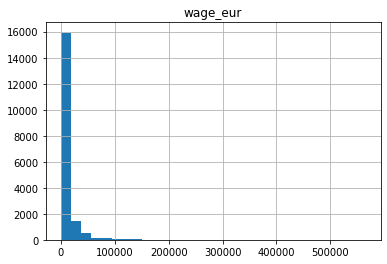

In [0]:
players_20.hist(column='wage_eur', bins=30)

In [0]:
dist_df = players_20.copy()
dist_df = dist_df[dist_df['wage_eur'] < 20000]
scaled_wage = MinMaxScaler(feature_range=(0, 100)).fit_transform(dist_df['wage_eur'].to_numpy().reshape(-1, 1)).reshape(-1)

fig = make_subplots(rows=2, cols=1, 
                    shared_xaxes=True,
                    specs=[[{"rowspan": 1}], [{"rowspan": 1}]], 
                    vertical_spacing=0.02)


fig.add_trace(go.Histogram(x=scaled_wage.round().astype(int), xbins={ 'start': 0, 'end': 100, 'size': 5}, name='wage_euro'), row=2, col=1)
fig.add_trace(go.Histogram(x=df['overall'], xbins={ 'start': 0, 'end': 100, 'size': 5}, name='overall'), row=2, col=1)

# Use x instead of y argument for horizontal plot
fig.add_trace(go.Box(x=scaled_wage.round().astype(int), showlegend=False, marker_color="#636EFA"), row=1, col=1)
fig.add_trace(go.Box(x=df['overall'], showlegend=False, marker_color="#EF553B"), row=1, col=1)

# Overlay both histograms
fig.update_layout(barmode='overlay')

# Reduce opacity to see both histograms
fig.update_traces(opacity=0.75)

fig.update_layout(height=600, width=1000)
fig.update_yaxes(title_text="Number of Players", row=2, col=1)
fig.show()

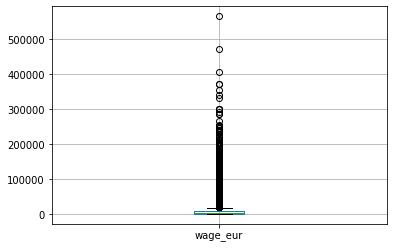

In [0]:
players_20.boxplot(column='wage_eur')

## 3.3 Age

In [0]:
df_grouped_by_age_range = players_20.groupby(pd.cut(players_20['age'], np.arange(15, 45, 5)))

# mean wage
mean_wage_per_age = df_grouped_by_age_range.wage_eur.mean().reset_index()
mean_wage_per_age['age'] = mean_wage_per_age.age.astype(str)

# median wage
median_wage_per_age = df_grouped_by_age_range.wage_eur.median().reset_index()
median_wage_per_age['age'] = median_wage_per_age.age.astype(str)

# Create traces
fig = make_subplots(rows=1, cols=2, column_widths=[0.35, 0.65])

fig.add_trace(go.Violin(y=players_20['age'], x0='Age', name='age'), row=1, col=1)

fig.add_trace(go.Scatter(x=mean_wage_per_age['age'], y=mean_wage_per_age['wage_eur'],
                    mode='lines+markers',
                    name='mean wage'), row=1, col=2)
fig.add_trace(go.Scatter(x=median_wage_per_age['age'], y=median_wage_per_age['wage_eur'],
                    mode='lines+markers',
                    name='median wage'), row=1, col=2)

fig.update_yaxes(title_text="Wage", row=1, col=2)
fig.update_xaxes(title_text="Age Group", row=1, col=2)

fig.update_layout(height=500, width=1000)

fig.show()

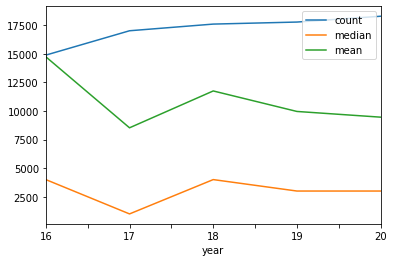

In [0]:
players_dfs = []
fifa_versions = {
    '16': players_16,
    '17': players_17,
    '18': players_18,
    '19': players_19,
    '20': players_20
}

for version in fifa_versions:
  df = fifa_versions[version].copy()
  df = df[['sofifa_id', 'wage_eur']]
  df['year'] = version
  players_dfs.append(df)

# concat all dfs
players = pd.concat(players_dfs)
players.groupby('year').wage_eur.count().plot()
players.groupby('year').wage_eur.median().plot()
players.groupby('year').wage_eur.mean().plot()
pyplot.legend(['count', 'median', 'mean'])

## 3.4 Club and League

In [0]:
league_value = players_20.groupby('league_name', as_index=False).wage_eur.sum().sort_values('wage_eur', ascending=False)

# the top 10
league_value_top_10 = league_value[:10].copy()

# others
new_row = pd.DataFrame(data = {
    'league_name' : ['others'],
    'wage_eur' : [league_value['wage_eur'][10:].sum()]
})

league_value = pd.concat([league_value_top_10, new_row])
fig = px.pie(league_value, values='wage_eur', names='league_name')
fig.show()

In [0]:
# country to iso_alpha helper df
countries_df = px.data.gapminder().query("year==2007")[['country', 'continent', 'iso_alpha']]
countries_df.country[countries_df.country=="United Kingdom"] = "England"
countries_df.country[countries_df.country=="United States"] = "USA"
countries_df.country[countries_df.country=="Cote d'Ivoire"] = "Côte d'Ivoire"
countries_df.country[countries_df.country=="Ireland"] = "Republic of Ireland"
countries_df.country[countries_df.country=="Korea, Rep."] = "Korea Republic"

# merge player and country df
players_20_country = pd.merge(players_20, countries_df, left_on='team_country', right_on='country', how='left')

# select top 200 players of each country
players_20_country = players_20_country.groupby(["team_country"]).apply(lambda x: x.sort_values(["wage_eur"], ascending = False)).reset_index(drop=True)
players_20_country = players_20_country.groupby('team_country').head(200)

# calculate mean wage per country
players_20_country = players_20_country.groupby(['team_country', 'continent', 'iso_alpha']).agg({'wage_eur': ['mean', 'min', 'max'], 'sofifa_id': ['count']})
players_20_country.columns = ['wage_mean', 'wage_min', 'wage_max', 'players_count']

# reset index to get grouped columns back
players_20_country = players_20_country.reset_index()

# plot world map
fig = px.scatter_geo(players_20_country, locations="iso_alpha", color="continent",
                     hover_name="team_country", size="wage_mean",
                     projection="natural earth")
fig.show()

## 3.5 Player position

In [0]:
position_player_type = {
    'CF': 'Forward',
    'RF': 'Forward',
    'LF': 'Forward',
    'ST': 'Forward',
    'LW': 'Midfielder',
    'RW': 'Midfielder',
    'CDM': 'Midfielder',
    'LM': 'Midfielder',
    'RM': 'Midfielder',
    'LCM': 'Midfielder',
    'CM': 'Midfielder',
    'RCM': 'Midfielder',
    'CAM': 'Midfielder',
    'LCB': 'Midfielder',
    'LDM': 'Midfielder',
    'CB': 'Defender',
    'RCB': 'Defender',
    'LB': 'Defender',
    'RB': 'Defender',
    'LWB': 'Defender',
    'RWB': 'Defender',
    'GK': 'Goal Keeper'
}

In [0]:
league_value = players_20.groupby('league_name', as_index=False).wage_eur.sum().sort_values('wage_eur', ascending=False)

# the top 10 leagures
top_leagues = league_value[:10].copy()['league_name'].tolist()
position_df = players_20.copy()
position_df = position_df[position_df['league_name'].isin(top_leagues)]
position_df['aggregated_position'] = position_df['player_positions'].apply(lambda positions: position_player_type[positions.split(', ')[0]])

position_df = position_df.groupby(['league_name', 'aggregated_position'])['wage_eur'].mean()

# unstack df
position_df = position_df.unstack()

fig = go.Figure(data=go.Heatmap(
        z=[[g, d, m, f] for g, d, m, f in zip(position_df['Goal Keeper'], position_df['Defender'], position_df['Midfielder'], position_df['Forward'])],
        x=['Goal Keeper', 'Defender', 'Midfielder', 'Forward'],
        y=position_df.index.tolist(),
        colorscale='Viridis'))

fig.update_layout(
    title='Average wage per player position',
    xaxis_nticks=36)

fig.show()

# 4 Feature Engeneering

In [0]:
# remove unnecessary columns
feature_df = players_20.copy()
feature_df = feature_df.drop(['sofifa_id', 'player_url', 'short_name', 'long_name', 'dob', 'real_face', 'release_clause_eur', 'team_country', 'player_tags', 'team_jersey_number', 'nation_position', 'nation_jersey_number'], axis=1)

work_rate_level_map = { 'Low': 0, 'Medium': 1, 'High': 2 }
club_budget_df = players_20.groupby(['club']).wage_eur.sum()
nationality_wage_df = players_20.groupby(['nationality']).wage_eur.median()

# prepare features
for i, player in feature_df.iterrows():
  # position stats
  positions_list = player['player_positions'].split(', ')
  feature_df.at[i,'positions_length'] = len(positions_list)

  for pos_index, position in enumerate(positions_list):
    if position != 'GK':
      position_stats = player[position.lower()]
      position_stats_without_rep_boost = re.search(r'\d+', position_stats).group()
      feature_df.at[i,'stats_position_' + str(pos_index + 1)] = position_stats_without_rep_boost

  # group position to goal keeper, defender, midfielder and forward
  feature_df.at[i, 'grouped_player_position'] = position_player_type[positions_list[0]]
  
  # Body-Mass-Index (BMI)
  feature_df.at[i, 'bmi'] = round(player['weight_kg'] / ((player['height_cm'] / 100)**2), 2)

  # split work rate
  work_rates = player['work_rate'].split('/')
  feature_df.at[i, 'attacking_work_rate'] = work_rate_level_map[work_rates[0]]
  feature_df.at[i, 'defensive_work_rate'] = work_rate_level_map[work_rates[1]]

  # months playing for the club
  if not pd.isna(player['joined']):
    joined_date = datetime.strptime(player['joined'], '%Y-%m-%d')
    data_extraction_date = datetime(2020, 1, 1)
    feature_df.at[i, 'years_playing_for_current_club'] = round((data_extraction_date - joined_date).days / 365, 2)
  else:
    feature_df.at[i, 'years_playing_for_current_club'] = 0

  # loaned
  feature_df.at[i, 'loaned'] = not pd.isna(player['loaned_from'])

  # target encode club (budget)
  feature_df.at[i, 'club_budget'] = club_budget_df[player['club']]

  # target encode nationality (median wage)
  feature_df.at[i, 'nationality_median_wage'] = nationality_wage_df[player['nationality']]
   

# format object columns to int
for column in ['stats_position_1', 'stats_position_2', 'stats_position_3']:
  feature_df[column].fillna(0, inplace=True)
  feature_df[column] = feature_df[column].astype(str).astype(int)

# drop obsolet columns
feature_df = feature_df.drop(['loaned_from', 'club', 'nationality', 'joined', 'work_rate', 'value_eur', 'player_positions', 'player_traits', 'ls', 'st', 'rs', 'lw', 'lf', 'cf', 'rf', 'rw', 'lam', 'cam', 'ram', 'lm', 'lcm', 'cm', 'rcm', 'rm', 'lwb', 'ldm', 'cdm', 'rdm', 'rwb', 'lb', 'lcb', 'cb', 'rcb', 'rb'], axis=1)

# encode all categorical columns
categorical_feature_mask = feature_df.dtypes==object
categorical_cols = feature_df.columns[categorical_feature_mask].tolist()

# one hot encode
one_hot_encode_cols = ['grouped_player_position', 'team_position', 'league_name', 'body_type']
one_hot_encode_df = pd.get_dummies(feature_df[one_hot_encode_cols])

feature_df = pd.concat([feature_df, one_hot_encode_df], axis=1)
feature_df = feature_df.drop(one_hot_encode_cols, axis=1)

# label encode binary cols
label_encode_cols = [x for x in categorical_cols if x not in one_hot_encode_cols]
label_encoder = LabelEncoder()
feature_df[label_encode_cols] = feature_df[label_encode_cols].apply(lambda col: label_encoder.fit_transform(col.astype(str)))

In [65]:
feature_df.head()

,age,height_cm,weight_kg,overall,potential,wage_eur,preferred_foot,international_reputation,weak_foot,skill_moves,contract_valid_until,pace,shooting,passing,dribbling,defending,physic,gk_diving,gk_handling,gk_kicking,gk_reflexes,gk_speed,gk_positioning,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,...,league_name_French Ligue 1,league_name_French Ligue 2,league_name_German 1. Bundesliga,league_name_German 2. Bundesliga,league_name_German 3. Bundesliga,league_name_Greek Super League,league_name_Holland Eredivisie,league_name_International,league_name_Italian Serie A,league_name_Italian Serie B,league_name_Japanese J. League Division 1,league_name_Korean K League Classic,league_name_Mexican Liga MX,league_name_Norwegian Eliteserien,league_name_Polish T-Mobile Ekstraklasa,league_name_Portuguese Liga ZON SAGRES,league_name_Rep. Ireland Airtricity League,league_name_Romanian Liga I,league_name_Russian Premier League,league_name_Saudi Abdul L. Jameel League,league_name_Scottish Premiership,league_name_South African Premier Division,league_name_Spain Primera Division,league_name_Spanish Segunda División,league_name_Swedish Allsvenskan,league_name_Swiss Super League,league_name_Turkish Süper Lig,league_name_UAE Arabian Gulf League,league_name_USA Major League Soccer,league_name_Ukrainian Premier League,body_type_Akinfenwa,body_type_C. Ronaldo,body_type_Courtois,body_type_Lean,body_type_Messi,body_type_Neymar,body_type_Normal,body_type_PLAYER_BODY_TYPE_25,body_type_Shaqiri,body_type_Stocky
0,32,170,72,94,94,565000,0,5,4,4,2021.0,87.0,92.0,92.0,96.0,39.0,66.0,NaN,NaN,NaN,NaN,NaN,NaN,88,95,70,92,88,97,93,94,92,96,91,84,93,95,95,86,68,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1,34,187,83,93,93,405000,1,5,4,5,2022.0,90.0,93.0,82.0,89.0,35.0,78.0,NaN,NaN,NaN,NaN,NaN,NaN,84,94,89,83,87,89,81,76,77,92,89,91,87,96,71,95,95,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2,27,175,68,92,92,290000,1,5,5,5,2022.0,91.0,85.0,87.0,95.0,32.0,58.0,NaN,NaN,NaN,NaN,NaN,NaN,87,87,62,87,87,96,88,87,81,95,94,89,96,92,84,80,61,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,26,188,87,91,93,125000,1,3,3,1,2023.0,NaN,NaN,NaN,NaN,NaN,NaN,87.0,92.0,78.0,89.0,52.0,90.0,13,11,15,43,13,12,13,14,40,30,43,60,67,88,49,59,78,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,28,175,74,91,91,470000,1,4,4,4,2024.0,91.0,83.0,86.0,94.0,35.0,66.0,NaN,NaN,NaN,NaN,NaN,NaN,81,84,61,89,83,95,83,79,83,94,94,88,95,90,94,82,56,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


# 5 Modeling

## 5.1 Data preprocessing

In [0]:
# feature_importance_df = pd.read_csv(os.path.join(project_dir, 'data', 'features_after_L1.csv'))
feature_importance_df = pd.read_csv(os.path.join(project_dir, 'data', 'features_after_L2.csv'))

X = feature_df.drop(['wage_eur'], axis=1)
X = X[feature_importance_df['feature']]

y = feature_df['wage_eur']

# create 10 bins. 
bins = np.linspace(0, 300000, 10)

# save Y values in a new ndarray,
# broken down by the bins created above.
y_binned = np.digitize(y, bins)

# pass y_binned to the stratify argument,

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y_binned, random_state=42, shuffle=True)

In [12]:
# print distribution of each class
(unique, counts) = np.unique(y_binned, return_counts=True)
frequencies = np.asarray((unique, counts)).T
print(frequencies)

[[    1 17185]
 [    2   737]
 [    3   183]
 [    4    61]
 [    5    47]
 [    6    22]
 [    7    16]
 [    8    13]
 [    9     3]
 [   10    11]]


## 5.2 Hyper-Parameter Tuning

In [0]:
# parameter grid for XGBoost
param_grid = {
  # 'reg_alpha': [1, 2, 4]
  # 'reg_lambda': [0.5, 1, 2, 3]
}

In [120]:
xgb_model = XGBRegressor(objective="reg:squarederror", random_state=42, reg_alpha=0, reg_lambda=1)

kfold = KFold(n_splits=5, shuffle=True, random_state=42)

grid_search = GridSearchCV(xgb_model, param_grid, scoring="neg_root_mean_squared_error", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X_train, y_train)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
	print("%f (%f) with: %r" % (mean, stdev, param))

Best: -3192.129721 using {}
-3192.129721 (459.730037) with: {}


In [121]:
# check importance of features
pd.set_option('display.float_format', lambda x: '%.3f' % x)
importance_dic = grid_result.best_estimator_.get_booster().get_score(importance_type="weight")
feature_importance_df = pd.DataFrame(importance_dic.items(), columns=['feature', 'importance'])
feature_importance_df

,feature,importance
0,overall,485
1,club_budget,726
2,stats_position_1,124
3,mentality_penalties,120
4,age,253
...,...,...
113,team_position_ST,1
114,league_name_Chilian Campeonato Nacional,1
115,loaned,2
116,team_position_RCB,1


In [0]:
# save selected features
feature_importance_df.to_csv(os.path.join(project_dir, 'data', 'features_after_L2.csv'), index=False) 

In [218]:
# converting the dataframe into XGBoost’s Dmatrix object
dtrain = xgb.DMatrix(X_train, label=y_train)

# bayesian optimization function for xgboost
def bo_tune_xgb(max_depth, gamma, num_boost_round ,eta):
    params = {
      'max_depth': int(max_depth),
      'gamma': gamma,
      'subsample': 0.8,
      'eta': eta,
      'eval_metric': 'rmse',
      'lambda': 1
    }
    # cross validating with the specified parameters in 5 folds
    cv_result = xgb.cv(params, dtrain, num_boost_round=int(num_boost_round), nfold=5, seed=42)
    # return the negative RMSE
    return -1.0 * cv_result['test-rmse-mean'].iloc[-1]

# invoking bayesian optimizer with the specified parameters to tune
xgb_bo = BayesianOptimization(
    bo_tune_xgb,
    {
        'max_depth': (3, 10),
        'gamma': (0, 1),
        'eta':(0,1),
        'num_boost_round':(200,600)
    }
)

# performing bayesian optimization for 5 iterations with 8 steps of random exploration with an
# acquisition function of expected improvement
xgb_bo.maximize(n_iter=10, init_points=8, acq='ei')

|   iter    |  target   |    eta    |   gamma   | max_depth | num_bo... |
-------------------------------------------------------------------------
|  1        | -5.441e+0 |  0.9837   |  0.9945   |  4.722    |  595.8    |
|  2        | -5.31e+03 |  0.8636   |  0.8941   |  4.816    |  208.0    |
|  3        | -3.257e+0 |  0.2611   |  0.2818   |  7.115    |  409.3    |
|  4        | -3.216e+0 |  0.3071   |  0.3171   |  3.324    |  417.3    |
|  5        | -4.556e+0 |  0.7895   |  0.9354   |  3.348    |  414.4    |
|  6        | -4.643e+0 |  0.6893   |  0.7262   |  7.696    |  561.7    |
|  7        | -3.759e+0 |  0.4709   |  0.1989   |  9.874    |  414.2    |
|  8        | -2.708e+0 |  0.07071  |  0.5816   |  6.778    |  476.2    |
|  9        | -2.934e+0 |  0.1689   |  0.03981  |  6.46     |  341.2    |
|  10       | -4.691e+0 |  0.6873   |  0.4958   |  9.11     |  250.4    |
|  11       | -2.709e+0 |  0.08697  |  0.4961   |  5.588    |  413.7    |
|  12       | -6.266e+0 |  0.9954   | 

In [219]:
# extract best parameters
params = xgb_bo.max['params']

# save prams
with open(os.path.join(project_dir, 'data', 'best_params.json'), 'w') as fp:
    json.dump(params, fp)

print(params)

{'eta': 0.07071148684063122, 'gamma': 0.5815777822335039, 'max_depth': 6.778464084435456, 'num_boost_round': 476.2014433219181}


In [235]:
xgb_model = XGBRegressor(
    objective="reg:squarederror",
    random_state=42,
    reg_lambda=1,
    subsample=0.8,
    max_depth=7,
    n_estimators=467,
    learning_rate=0.07,
    gamma=0.58
)

kfold = KFold(n_splits=5, shuffle=True, random_state=42)
cv_results = cross_validate(xgb_model, X_train, y_train, cv=kfold, scoring={'rsme': 'neg_root_mean_squared_error', 'mae': 'neg_mean_absolute_error'})

# summarize results
print("RMSE: %.2f (%.2f)" % (cv_results['test_rsme'].mean()*-1, cv_results['test_rsme'].std()))
print("MAE: %.2f (%.2f)" % (cv_results['test_mae'].mean()*-1, cv_results['test_mae'].std()))

RMSE: 2883.43 (396.37)
MAE: 941.55 (34.14)


In [0]:
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=X_train.columns)
dtest = xgb.DMatrix(X_test, label=y_test, feature_names=X_test.columns)

In [0]:
final_params = {
  'objective': "reg:squarederror",
  'lambda': 1,
  'subsample': 0.8,
  'max_depth': 7,
  'eta': 0.07,
  'gamma': 0.58,
  'seed': 42
}

# train final model
final_xgb_model = xgb.train(final_params, dtrain, num_boost_round=467)

# 6 Evaluation

In [0]:
x_train_nafilled = X_train.fillna(0)
x_test_nafilled = X_test.fillna(0)

Basline Model (Mean)

In [0]:
basline_results = []
for train_index, test_index in kfold.split(X):
  X_train, X_test = X.iloc[train_index], X.iloc[test_index]
  y_train, y_test = y.iloc[train_index], y.iloc[test_index]

  # calculate rmse for each fold
  avg_train_wage = np.mean(y_train)
  y_pred_basline = [avg_train_wage] * X_test.shape[0]
  mse=mean_squared_error(y_test, y_pred_basline)
  basline_results.append(np.sqrt(mse))

basline_results = np.array(basline_results)

# print results
print("RMSE: %.2f (%.2f)" % (basline_results.mean(), basline_results.std()))

RMSE: 21243.44 (2148.79)


Linear Regression

In [252]:
reg = LinearRegression().fit(x_train_nafilled, y_train)

# train eval
y_pred_reg = reg.predict(x_train_nafilled)
print("RMSE: " + str(np.sqrt(mean_squared_error(y_train, y_pred_reg))))
print("MAE: " + str(mean_absolute_error(y_train, y_pred_reg)))

# test eval
y_pred_reg = reg.predict(x_test_nafilled)
print("RMSE: " + str(np.sqrt(mean_squared_error(y_test, y_pred_reg))))
print("MAE: " + str(mean_absolute_error(y_test, y_pred_reg)))

RMSE: 10090.66170829659
MAE: 4898.626035549551
RMSE: 10434.499596491127
MAE: 4752.378103448047


Support Vector Machine (SVM)

In [14]:
svr_rbf = SVR(kernel='poly', C=1e4, degree=2)
svr_rbf.fit(x_train_nafilled, y_train)

SVR(C=10000.0, cache_size=200, coef0=0.0, degree=2, epsilon=0.1, gamma='scale',
    kernel='poly', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [15]:
# train eval
y_pred_svm = svr_rbf.predict(x_train_nafilled)
print("RMSE: " + str(np.sqrt(mean_squared_error(y_train, y_pred_svm))))
print("MAE: " + str(mean_absolute_error(y_train, y_pred_svm)))

# test eval
y_pred_svm = svr_rbf.predict(x_test_nafilled)
print("RMSE: " + str(np.sqrt(mean_squared_error(y_test, y_pred_svm))))
print("MAE: " + str(mean_absolute_error(y_test, y_pred_svm)))

RMSE: 16670.042770866166
MAE: 6306.296595542264
RMSE: 15379.665167140865
MAE: 5856.8133748858545


Random Forest

In [255]:
random_forest = RandomForestRegressor(max_depth=6, random_state=42).fit(x_train_nafilled, y_train)

# train eval
y_pred_rf = random_forest.predict(x_train_nafilled)
print("RMSE: " + str(np.sqrt(mean_squared_error(y_train, y_pred_rf))))
print("MAE: " + str(mean_absolute_error(y_train, y_pred_rf)))

# test eval
y_pred_rf = random_forest.predict(x_test_nafilled)
print("RMSE: " + str(np.sqrt(mean_squared_error(y_test, y_pred_rf))))
print("MAE: " + str(mean_absolute_error(y_test, y_pred_rf)))

RMSE: 3104.156810967636
MAE: 1613.6402184568142
RMSE: 5017.222410520563
MAE: 1842.248011044158


XGBoost

In [224]:
y_pred_xgboost = final_xgb_model.predict(dtest)
print("RMSE: " + str(np.sqrt(mean_squared_error(y_test, y_pred_xgboost))))
print("MAE: " + str(mean_absolute_error(y_test, y_pred_xgboost)))

RMSE: 3753.58499704357
MAE: 935.7096432705677


# 7 Interpretation

In [19]:
# explain the model's predictions using SHAP
explainer = shap.TreeExplainer(final_xgb_model)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


In [0]:
shap_values = explainer.shap_values(dtest, check_additivity=False)

In [89]:
shap.initjs()

# visualize the prediction's explanation of Bakery Jatta (Hamburger SV)
shap.force_plot(explainer.expected_value, shap_values[138,:], X_test.iloc[138,:])

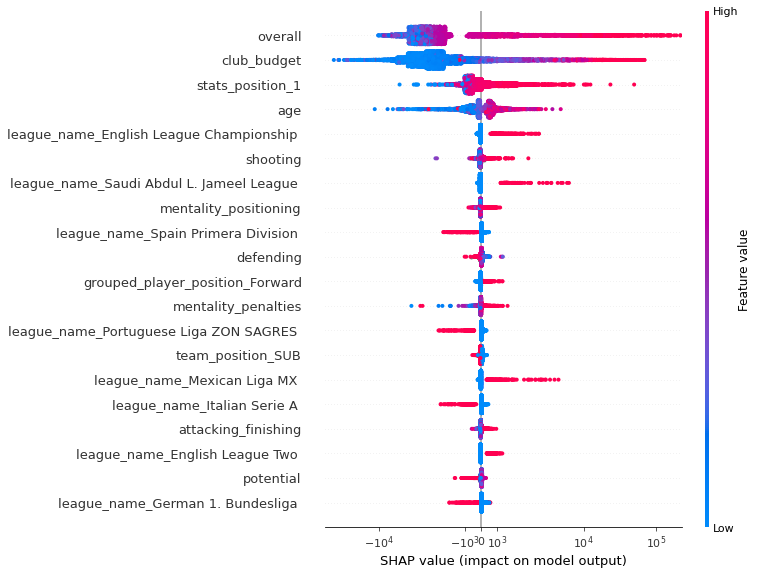

In [32]:
shap.initjs()

# summarize the effects of all the features
shap.summary_plot(shap_values, X_test, log_scale=True, linthreshx=5000)